## Prerequisite Packages

In [1]:
# Based on https://www.tensorflow.org/datasets/keras_example
# use pip install <package> to find any packages that are missing
import keras         # for fitting DNNs
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score
from matplotlib import pyplot as plt
from keras import backend as K
from sklearn.manifold import TSNE

## We split the data into training and testing

In [2]:
(ds_train,ds_val, ds_test), ds_info = tfds.load(
    'mnist',
#     split=['train[:80%]','train[80%:]','test'],
    split=[
   tfds.Split.TRAIN.subsplit(tfds.percent[:80]),
   tfds.Split.TRAIN.subsplit(tfds.percent[80:90]),
   tfds.Split.TRAIN.subsplit(tfds.percent[90:])
],
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
)


## Functions: normalizing images, and returning labels/images

In [3]:
#ds_test.astype(np.float32)
#image = np.expand_dims(np.expand_dims(image, axis=2), axis=0)
#image = np.concatenate((image, 0.5*image), 0)
#image = np.concatenate((image, 0.5*image), 0)
#image3D = np.expand_dims(image, axis=0)
#image3D = np.concatenate((image3D, 0.5*image3D), 0)


def normalize_img(image, label):
  """Normalizes images: `uint8` -> `float32`."""
  return tf.cast(image, tf.float32) / 255., label
def normalize_transpose_img(image, label):
  """Normalizes images: `uint8` -> `float32`."""
  return tf.transpose(tf.cast(image, tf.float32) / 255.), label

def get_label(image,label):
    return label
def get_image(image,label):
    return image


## We apply these functions to extract model-ready data

In [4]:
# this just normalizes the image
ds_train = ds_train.map(
    normalize_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)

# cache and prefetch save memory 
ds_train = ds_train.cache()

# we shuffle data (reduces effects of order when training model)
ds_train = ds_train.shuffle(ds_info.splits['train[:80%]'].num_examples)

# batch size tells us how many samples are needed for stochastic gradient descent 
# (a small number like 32 is empirically found to be better)
ds_train = ds_train.batch(32)# batch of 32
ds_train = ds_train.prefetch(tf.data.experimental.AUTOTUNE)


ds_val = ds_val.map(
    normalize_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)
ds_val = ds_val.cache()

ds_val = ds_val.shuffle(ds_info.splits['train[80%:]'].num_examples)

ds_val = ds_val.batch(32)# batch of 32
ds_val = ds_val.prefetch(tf.data.experimental.AUTOTUNE)


ds_test_label=ds_test.map(
    get_label, num_parallel_calls=tf.data.experimental.AUTOTUNE)
ds_test_images=ds_test.map(
    get_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)

print(ds_test)
#image = ds_test.astype(np.float32)
#image = np.expand_dims(np.expand_dims(image, axis=2), axis=0)
#image = np.concatenate((image, 0.5*image), 0)
#image = np.concatenate((image, 0.5*image), 0)
#image3D = np.expand_dims(image, axis=0)
#image3D = np.concatenate((image3D, 0.5*image3D), 0)

ds_test_trans = ds_test.map(normalize_transpose_img)
ds_test_trans_images=ds_test_trans.map(get_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
ds_test_trans = ds_test_trans.batch(32)
ds_test_trans = ds_test_trans.cache()
ds_test_trans = ds_test_trans.prefetch(tf.data.experimental.AUTOTUNE)


ds_test = ds_test.map(
    normalize_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)
ds_test = ds_test.batch(32)
ds_test = ds_test.cache()
ds_test = ds_test.prefetch(tf.data.experimental.AUTOTUNE)


KeyError: "Invalid split train[:80%]. Available splits are: ['test', 'train']"

## Model training

In [10]:
# this example model
#    - first flattens data into a vector (image is 28 x 28)
#    - then creates a dense 128-node layer
#    - then creates a dropout "layer" (it says how many nodes are dropped out in previous layer)
#    - then another 128-node layer
#    - and finally 10-node layer as the head.
# The max value of the head = the predicted image
#


dense = False
if dense:
    model = tf.keras.models.Sequential(
        [
            tf.keras.layers.Flatten(input_shape=(28, 28)),
            tf.keras.layers.Dense(56, activation="relu"),
            tf.keras.layers.Dropout(0.2, input_shape=(56,)),
            tf.keras.layers.Dense(24, activation="relu"),
            tf.keras.layers.Dense(10),
        ]
    )
else:
    model = tf.keras.models.Sequential([])
    model.add(
        tf.keras.layers.Conv2D(
            64, kernel_size=3, activation="relu", input_shape=(28, 28, 1)
        )
    )
    # model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Conv2D(32, kernel_size=3, activation="relu"))
    # model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Dropout(0.5))
    # model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2),strides=(1, 1), padding='valid'))
    model.add(tf.keras.layers.Flatten())
    # model.add(tf.keras.layers.BatchNormalization())
    # tf.keras.layers.Dense(24,activation='relu'),
    model.add(tf.keras.layers.Dense(10))
# this specifies how we find the best NN
# - Optimizer like Adam is found to work well
# - Loss is "sparse categorical cross entropy" (you can choose whatever loss function on keras improves your model)
# - We also record accuracy ("metric"), this does not affect training
model.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
)
# this is stuff we record
# "early stopping" tells us when we found the optimum without training more epochs
my_callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=1),
    tf.keras.callbacks.ModelCheckpoint(filepath="model.{epoch:02d}-{val_loss:.2f}.h5"),
    tf.keras.callbacks.TensorBoard(log_dir="./logs"),
]

# the training of the model
# we use ds_train data, and up to 30 epochs (less when Early Stopping is used)
# we also record callbacks, and we determine the optimal model by where validation is smallest
history = model.fit(ds_train, epochs=30, callbacks=my_callbacks, validation_data=ds_val)

Epoch 1/30


ValueError: in user code:

    C:\Users\erica\anaconda3\envs\dsci552\lib\site-packages\tensorflow\python\keras\engine\training.py:806 train_function  *
        return step_function(self, iterator)
    C:\Users\erica\anaconda3\envs\dsci552\lib\site-packages\tensorflow\python\keras\engine\training.py:796 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    C:\Users\erica\anaconda3\envs\dsci552\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:1211 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    C:\Users\erica\anaconda3\envs\dsci552\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2585 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    C:\Users\erica\anaconda3\envs\dsci552\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2945 _call_for_each_replica
        return fn(*args, **kwargs)
    C:\Users\erica\anaconda3\envs\dsci552\lib\site-packages\tensorflow\python\keras\engine\training.py:789 run_step  **
        outputs = model.train_step(data)
    C:\Users\erica\anaconda3\envs\dsci552\lib\site-packages\tensorflow\python\keras\engine\training.py:747 train_step
        y_pred = self(x, training=True)
    C:\Users\erica\anaconda3\envs\dsci552\lib\site-packages\tensorflow\python\keras\engine\base_layer.py:976 __call__
        self.name)
    C:\Users\erica\anaconda3\envs\dsci552\lib\site-packages\tensorflow\python\keras\engine\input_spec.py:196 assert_input_compatibility
        str(x.shape.as_list()))

    ValueError: Input 0 of layer sequential is incompatible with the layer: : expected min_ndim=4, found ndim=3. Full shape received: [28, 28, 1]


## Here we check the accuracy in the held-out test dataset

In [11]:

gt_labels=list(ds_test_label)
predictions=[np.argmax(im) for im in model.predict(ds_test)]
print(accuracy_score(predictions,gt_labels))



NameError: name 'ds_test_label' is not defined

## How does loss in training/validation vary with epoch?

In [ ]:
# These definitions make the plot code easier to read
minvalx=np.argmin(history.history['val_loss'])+1
minvaly=min(history.history['val_loss'])
mintrainx=np.argmin(history.history['loss'])+1
mintrainy=min(history.history['loss'])
lowpoint_val=np.array([[minvalx,-10],[minvalx,minvaly]])
lowpoint_train=np.array([[mintrainx,-10],[mintrainx,mintrainy]])

# N.B., it's always good to label axes and lines
plt.plot(list(range(1,len(history.history['val_loss'])+1)),history.history['val_loss'],'k-.',label='Validation Loss')
plt.plot(lowpoint_val[:,0],lowpoint_val[:,1],'kx-',markersize=10,label='Minimum Validation Loss')
plt.plot(list(range(1,len(history.history['loss'])+1)),history.history['loss'],'r--',label='Training Loss')
plt.plot(lowpoint_train[:,0],lowpoint_train[:,1],'r+-',markersize=10,label='Minimum Training Loss')
# creates legend from "label" attribute
plt.legend()
# y limit
plt.ylim([0,0.3])
# axes labels
plt.ylabel('Loss')
plt.xlabel('Epoch')
# show the plot
# to save figure, you can use plt.savefig(<file name>)
plt.show()


# Adversarial examples

In [3]:
# first, let's add noise to 1 image and see where it moves in t-SNE space

from scipy.special import softmax
noise=0.8
predictions2=[]
for i in range(10):#len(ds_test)):
    dat=[np.clip(im[:,:,0]+np.random.uniform(-noise,noise,size=im[:,:,0].shape),0,1) for im in np.array(list(ds_test)[i][0])]#

    im=dat[-1]
    dat=np.array(dat).reshape(32,28,28,1)
    transposed=tf.convert_to_tensor(dat)
    predictions2+=[np.argmax(pred) for pred in (model.predict([transposed]))]
    confidence = np.max(softmax(model.predict([transposed])[-1]))
    #if float(gt_labels[len(predictions2)-1]) != predictions2[-1]:
    #    if confidence > 0.1:
    print('Confidence: '+str(confidence))
    plt.imshow(im)
    plt.title('Predicted: '+str(predictions2[-1])+' Actual: '+str(int(float(gt_labels[len(predictions2)-1]))))
    plt.show()
#softmax(model.predict([list(ds_test)[0][0]])).shape


NameError: name 'ds_test' is not defined

In [4]:
batch_size=32
gt_labels=np.array(list(ds_test_label)[:(len(ds_test)-1)*batch_size]).reshape(len(ds_test)-1,batch_size).astype(float)

noise=0.3
results={'noise':[],'gt':[],'pred':[],'correct':[],'confidence':[]}
for noise in np.arange(0.0,2,0.1):
    print(noise)
    for i in range(100):#len(ds_test)-1):
        if i % 50 == 0:
            print(round(i/len(ds_test)*100,2))
        dat=[np.clip(im[:,:,0]+np.random.uniform(-noise,noise,size=im[:,:,0].shape),0,1) for im in np.array(list(ds_test)[i][0])]
        dat=np.array(dat).reshape(32,28,28,1)
        tensored=tf.convert_to_tensor(dat)
        #predictions2+=[np.argmax(pred) for pred in (model.predict([transposed]))]
        pred = np.argmax(model.predict([tensored]),axis=1)
        confidence = [np.max(softmax(v)) for v in model.predict([tensored])]
        gt = gt_labels[i]#[float(nn) for nn in gt_labels[i-1]]
        correct = (pred==gt).astype(int)
        results['noise']+=[noise]*batch_size
        results['gt']+=list(gt)
        results['pred']+=list(pred)
        results['correct']+=list(correct)
        #plt.imshow(dat[-1].reshape(28,28))
        #plt.show()
        #break
        results['confidence']+=list(confidence)
        #if float(gt = ) != predictions2[-1]:
        #    if confidence > 0.1:
        #print('Confidence: '+str(confidence))
        #plt.imshow(im)
        #plt.title('Predicted: '+str(predictions2[-1])+' Actual: '+str(int(float(gt_labels[len(predictions2)-1]))))
        #plt.show()

NameError: name 'ds_test_label' is not defined

## Data is actually very robust to random noise!

In [5]:
results = pd.DataFrame(results)
all_correct=[]
all_confidence=[]
for noise in np.arange(0,2,0.1):
    noise_results = results.loc[results['noise']==noise,]
    if len(noise_results)==0: continue
    noise_correct = np.mean(noise_results['correct'].values)
    noise_conf = np.mean(noise_results['confidence'].values)
    all_correct.append([noise,noise_correct])
    all_confidence.append([noise,noise_conf])
all_correct=np.array(all_correct)
all_confidence=np.array(all_confidence)
plt.plot(all_confidence[:,0],all_confidence[:,1],'r--',label='Confidence')
plt.plot(all_correct[:,0],all_correct[:,1],'k-',label='Accuracy')
plt.plot([0,2],[0.1,0.1],color='gray',linestyle='-.')
plt.legend()
plt.ylim([0,1])
plt.xlim([0,2])
plt.xlabel('Noise')
#plt.ylabel('Accuracy')
plt.show()
        
        
        
        
        
        

NameError: name 'results' is not defined

In [6]:

for ii,noise in enumerate(np.arange(0,2,0.1)):
    noise_results = results.loc[results['noise']==noise,]
    if len(noise_results)==0: continue
    plt.plot(noise_results['pred'],noise_results['gt'],'sg',ms=20,alpha=0.008)
    plt.ylim([0.5,9.5])
    plt.xlim([0.5,9.5])
    plt.xlabel('Prediction')
    plt.ylabel('Actual Number')
    plt.title('Noise = '+str(noise))
    plt.axes().set_aspect(1)
    plt.show()
    

NameError: name 'results' is not defined

## Can we stear predictions to a particular number?

### The goal is to be sneaky: we want to make adversarial examples that are not obviously wrong, easy to add perhaps in the wild

11


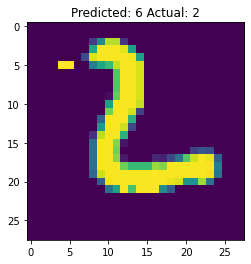

19


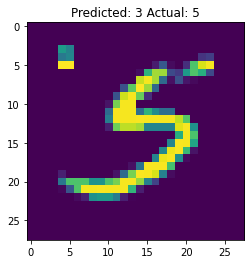

25


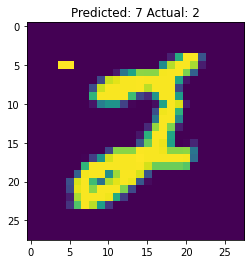

0.980625


In [165]:
im = np.array(list(ds_test)[0][0])
attack = np.zeros(shape=(28,28))
#for ii in range(12,25):
#    attack[ii,ii]=1
attack[5:6,4:6]=1
attack_results= {'noise':[],'gt':[],'pred':[],'correct':[],'confidence':[]}
for i in range(100):#len(ds_test)-1):
    dat=[np.clip(im[:,:,0]+attack,0,1) for im in np.array(list(ds_test)[i][0])]
    dat=np.array(dat).reshape(32,28,28,1)
    tensored=tf.convert_to_tensor(dat)
    #predictions2+=[np.argmax(pred) for pred in (model.predict([transposed]))]
    pred = np.argmax(model.predict([tensored]),axis=1)
    confidence = [np.max(softmax(v)) for v in model.predict([tensored])]
    gt = gt_labels[i]#[float(nn) for nn in gt_labels[i-1]]
    correct = (pred==gt).astype(int)
    attack_results['noise']+=[noise]*batch_size
    attack_results['gt']+=list(gt)
    attack_results['pred']+=list(pred)
    attack_results['correct']+=list(correct)
    attack_results['confidence']+=list(confidence)
    if pred[-1]!=int(gt[-1]):#i % 50 == 0:
        print(i)
        im = dat[-1].reshape(28,28)
        plt.imshow(im)
        plt.title('Predicted: '+str(pred[-1])+' Actual: '+str(int(gt[-1])))
        plt.show()
print(np.mean(attack_results['correct']))

11


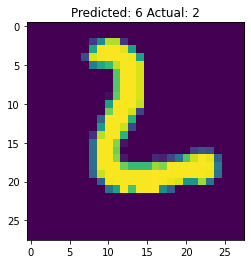

19


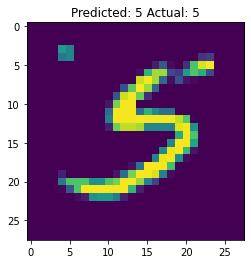

25


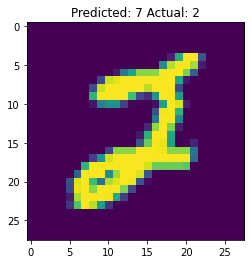

0.980625


In [166]:
im = np.array(list(ds_test)[0][0])
attack = np.zeros(shape=(28,28))
#for ii in range(12,25):
#    attack[ii,ii]=1
#attack[5:8,5:8]=1
#attack_results= {'noise':[],'gt':[],'pred':[],'correct':[],'confidence':[]}
for i in [11,19,25]:#len(ds_test)-1):
    dat=[np.clip(im[:,:,0]+attack,0,1) for im in np.array(list(ds_test)[i][0])]
    dat=np.array(dat).reshape(32,28,28,1)
    tensored=tf.convert_to_tensor(dat)
    #predictions2+=[np.argmax(pred) for pred in (model.predict([transposed]))]
    pred = np.argmax(model.predict([tensored]),axis=1)
    confidence = [np.max(softmax(v)) for v in model.predict([tensored])]
    gt = gt_labels[i]#[float(nn) for nn in gt_labels[i-1]]
    correct = (pred==gt).astype(int)
    #attack_results['noise']+=[noise]*batch_size
    #attack_results['gt']+=list(gt)
    #attack_results['pred']+=list(pred)
    #attack_results['correct']+=list(correct)
    #attack_results['confidence']+=list(confidence)
    #if pred[0]!=int(gt[0]):#i % 50 == 0:
    print(i)
    im = dat[-1].reshape(28,28)
    plt.imshow(im)
    plt.title('Predicted: '+str(pred[-1])+' Actual: '+str(int(gt[-1])))
    plt.show()
print(np.mean(attack_results['correct']))

### We can conclude that naive attacks can work well some of the time, can perform poorly all of the time, but can never work well all of the time. In contrast, more recent work has shown remarkable success through more nuanced attacks